# Dataset 1 - Regression

## Experiment Details 

The aim of the experiment is to verify if the:
1. ABC_GAN model corrects model misspecification
2. ABC_GAN model performs better and converges faster than a simple C-GAN model

In the experiment we predict the distribution that represents the real data and simulate realistic fake data points
using statistical mode, C-GAN and ABC-GAN model with 3 priors. We analyze and compare their performance using metrics like mean squared error, mean absolute error , manhattan distance and euclidean distance between $y_{real}$ and $y_{pred}$

The models are as follows:

1. The statistical model assumes the distribution $Y=\beta X + \mu$ where $\mu \sim N(0,1)$
2. The Conditional GAN consists of
    1. Generator with 2 hidden layers with 100 nodes each and ReLu activation.
    2. Discriminator with 2 hidden layers with 25 and 50 nodes and ReLu activation. 
    We use Adam's optimser and BCE Logit Loss to train the model. The input to the Generator of the GAN is (x,e) where x are the features and $e \sim N(0,1)$. The discriminator output is linear. 
3. The ABC GAN Model consists of 
    1. ABC generator is defined as follows:
        1. $Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 
        2. $\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else $\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from statistical model
        3. $\sigma^{*}$ takes the values 0.01,0.1 and 1      
    2. C-GAN network is as defined above. However the input to the Generator of the GAN is $(x,y_{abc})$ where $y_{abc}$ is the output of the ABC Generator.
        

## Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 10
n_samples= 100
 
#ABC Generator Parameters
mean = 1 
variance = 0.001

## Dataset

Generate a random regression problem

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [4]:
X,Y = regressionDataset.regression_data(n_samples,n_features)

         X1        X2        X3        X4        X5        X6        X7  \
0  0.782300 -0.221290  0.740052  0.844826  0.191738 -0.008238  0.689995   
1  1.086153 -0.952968  0.187427  0.171251  0.641671 -0.005732 -1.222726   
2  0.180527 -0.599969  1.781483  2.225735  0.646831  0.825950  0.335746   
3  0.170786 -1.356728 -0.309151  1.538965 -0.629930  0.877160  0.709751   
4  2.164461  0.238407  1.195390  0.195017  0.734556 -1.605710 -0.002508   

         X8        X9       X10           Y  
0  0.241082 -0.829550  1.382960  229.627539  
1  0.615418 -0.359490 -1.239861  -87.911289  
2 -2.325360  0.666619 -0.750053  145.034545  
3 -1.565300 -0.327436 -0.545767  -92.306831  
4 -1.266940  0.600564  0.385707  232.534533  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.126e+07
Date:                Sun, 17 Oct 2021   Prob (F-statistic):          1.07e-286
Time:                        20:03:47   Log-Likelihood:                 611.69
No. Observations:                 100   AIC:                            -1201.
Df Residuals:                      89   BIC:                            -1173.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.725e-17   5.66e-05   1.01e-12      1.0

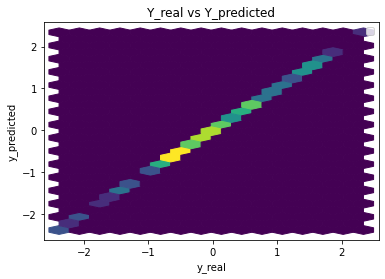

Performance Metrics
Mean Squared Error: 2.8473894692391287e-07
Mean Absolute Error: 0.000430008145844254
Manhattan distance: 0.04300081458442541
Euclidean distance: 0.005336093579800797


In [5]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [6]:
n_epochs = 5000
error = 0.1
batch_size = n_samples//2

## GAN Model

In [7]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [9]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=12, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=12, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


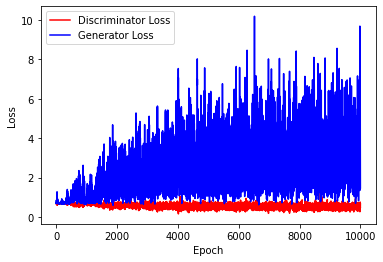

In [10]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

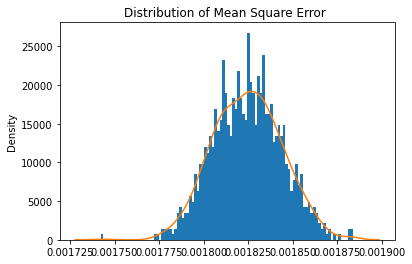

Mean Square Error: 0.00182467545460708


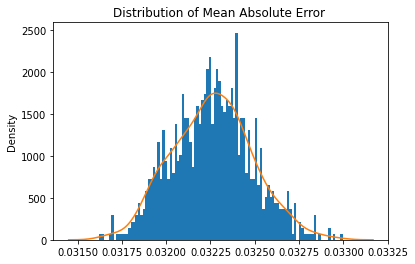

Mean Absolute Error: 0.032260448395814746


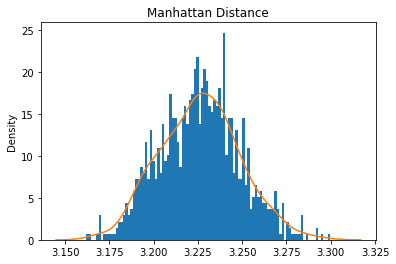

Mean Manhattan Distance: 3.2260448395814745


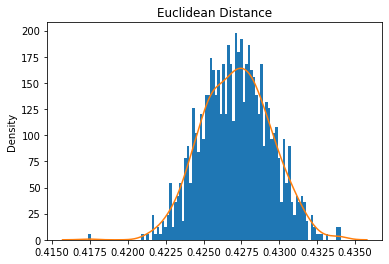

Mean Euclidean Distance: 0.42715623056157204


In [11]:
train_test.test_generator(generator,real_dataset,device)

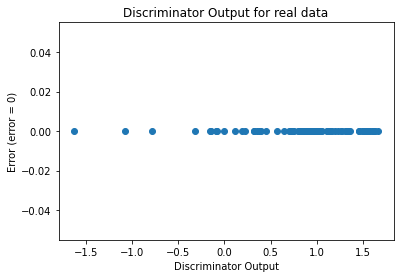

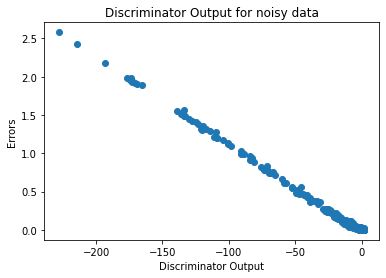

In [12]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

Number of epochs needed 0


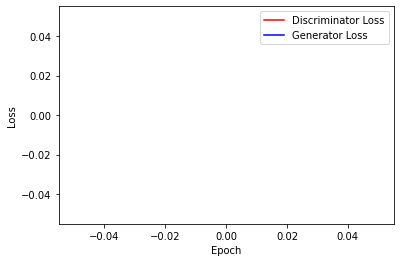

In [13]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

train_test.training_GAN_2(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size,error,criterion,device)

# ABC GAN Model

#### Training the network

In [14]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

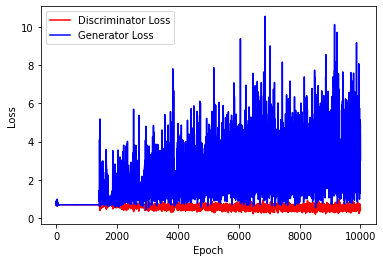

In [15]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

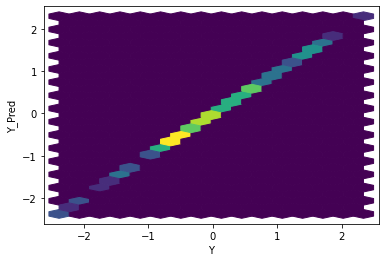

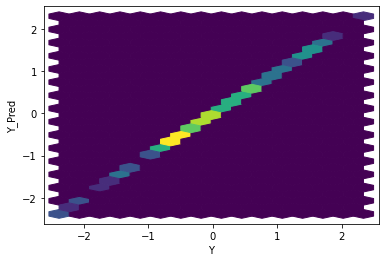

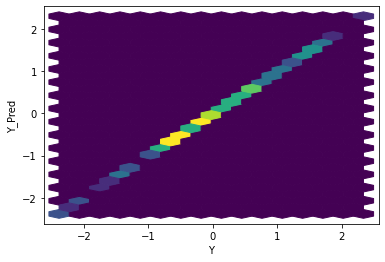

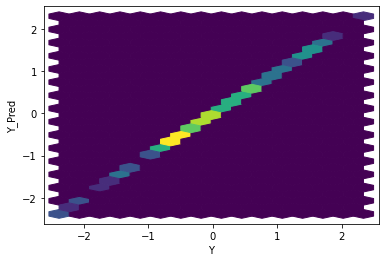

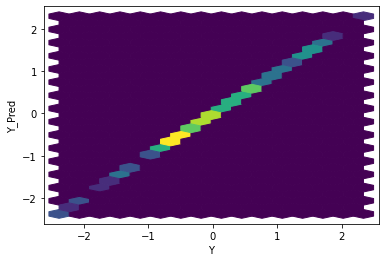

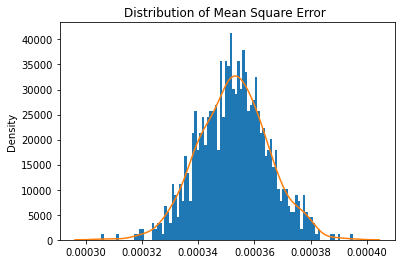

Mean Square Error: 0.000352598911253844


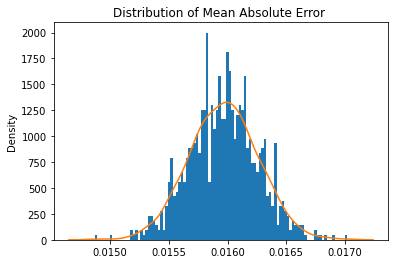

Mean Absolute Error: 0.015966899915430696
Mean Manhattan Distance: 1.5966899915430695


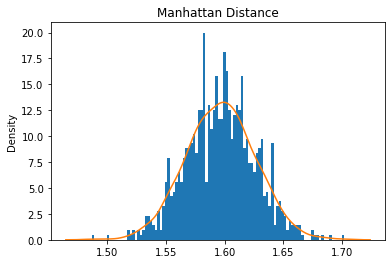

Mean Euclidean Distance: 0.18774714497653786


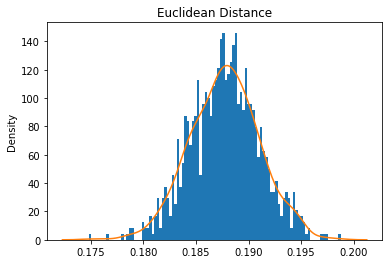

In [16]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

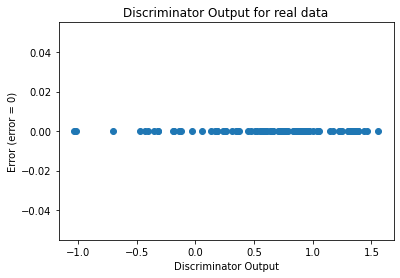

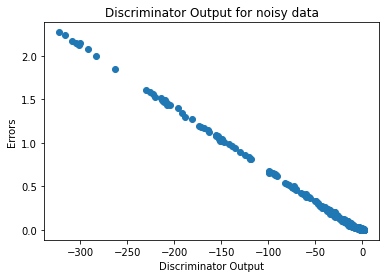

In [17]:
sanityChecks.discProbVsError(real_dataset,disc,device)